<a href="https://colab.research.google.com/github/240183078-vin/My-first-v/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 lxml pandas


In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
}


In [ ]:
#DATA SCRAPING, DONE BY VINCENT.T

In [ ]:
URL_TEMPLATES = {
    # 1) Discount catalog
    "discounts": (
        "https://arbuz.kz/ru/almaty/discount-catalog/225443-skidki"
        "?available=0&limit=52&page={page}"
    ),

    # 2) Main food categories
    "ovoshi_frukty_zelen": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225164-ovoshi_frukty_zelen"
        "?available=0&limit=52&page={page}"
    ),
    "kolbasy_i_delikatesy": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225167-kolbasy_i_delikatesy"
        "?available=0&limit=52&page={page}"
    ),
    "moloko_slivki_sgush": (
        "https://arbuz.kz/ru/almaty/catalog/cat/19986-moloko_slivki_sgush_nnoe_moloko"
        "?available=0&limit=52&page={page}"
    ),
    "myaso_i_ptica": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225162-myaso_i_ptica"
        "?available=0&limit=52&page={page}"
    ),
    "ryba_i_moreprodukty": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225752-ryba_i_moreprodukty"
        "?available=0&limit=52&page={page}"
    ),
    "zamorozhennye_produkty": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225183-zamorozhennye_produkty"
        "?available=0&limit=52&page={page}"
    ),
    "voda_i_napitki": (
        "https://arbuz.kz/ru/almaty/catalog/cat/14-voda_i_napitki"
        "?available=0&limit=52&page={page}"
    ),
    "orehi_suhofrukty_sneki": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225602-orehi_suhofrukty_i_sneki"
        "?available=0&limit=52&page={page}"
    ),
    "novyi_god": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224993-novyi_god"
        "?available=0&limit=52&page={page}"
    ),

    # 3) Extra categories you gave
    "eko_bio_vegan": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224645-eko_bio_vegan"
        "?available=0&limit=52&page={page}"
    ),
    "hleb_i_vypechka": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225165-hleb_i_vypechka"
        "?available=0&limit=52&page={page}"
    ),
    "zoo_magazin": (
        "https://arbuz.kz/ru/almaty/catalog/cat/20-zoo_magazin"
        "?available=0&limit=52&page={page}"
    ),
    "kosmetika_i_gigiena": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224407-kosmetika_i_sredstva_lichnoi_gigieny"
        "?available=0&limit=52&page={page}"
    ),
    "vs_dlya_doma": (
        "https://arbuz.kz/ru/almaty/catalog/cat/16-vs_dlya_doma"
        "?available=0&limit=52&page={page}"
    ),
    "dlya_detei_i_roditelei": (
        "https://arbuz.kz/ru/almaty/catalog/cat/19-dlya_detei_i_ih_roditelei"
        "?available=0&limit=52&page={page}"
    ),
    "bakaleya": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225169-bakaleya"
        "?available=0&limit=52&page={page}"
    ),
    "gotovaya_eda": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225253-gotovaya_eda"
        "?available=0&limit=52&page={page}"
    ),
}


In [ ]:
def scrape_collection(url_template, collection_name, max_pages=50):
    """
    Scrape one Arbuz collection or category.
    """
    all_products = []

    for page in range(1, max_pages + 1):
        url = url_template.format(page=page)
        resp = requests.get(url, headers=HEADERS)
        if resp.status_code != 200:
            print(f"[{collection_name}] stop at page {page}, status={resp.status_code}")
            break

        soup = BeautifulSoup(resp.text, "lxml")
        cards = soup.find_all(attrs={":product": True})
        if not cards:
            print(f"[{collection_name}] no products on page {page} → stop")
            break

        for card in cards:
            product_json = card[":product"]
            product = json.loads(product_json)
            all_products.append(product)

        print(f"[{collection_name}] page {page}: {len(cards)} products")

    if not all_products:
        return pd.DataFrame()

    df = pd.json_normalize(all_products)

    # keep only needed columns
    desired_cols = ["id", "catalogName", "brandName", "name",
                    "priceActual", "pricePrevious"]
    cols = [c for c in desired_cols if c in df.columns]
    df = df[cols].copy()

    df = df.rename(columns={
        "catalogName": "category",
        "brandName": "brand",
        "priceActual": "price_raw",
        "pricePrevious": "old_price_raw",
    })

    # ensure numeric prices
    df["price_raw"] = pd.to_numeric(df["price_raw"], errors="coerce")
    df["old_price_raw"] = pd.to_numeric(df["old_price_raw"], errors="coerce")

    # if old price missing or 0 → replace with current price
    df["old_price_raw"] = df["old_price_raw"].fillna(0)
    df.loc[df["old_price_raw"] == 0, "old_price_raw"] = df["price_raw"]

    # add which collection it came from (useful later)
    df["collection"] = collection_name

    return df


In [ ]:
frames = []

for name, template in URL_TEMPLATES.items():
    print(f"\n=== Scraping {name} ===")
    df_cat = scrape_collection(template, collection_name=name, max_pages=50)
    frames.append(df_cat)

# combine everything
df_all = pd.concat(frames, ignore_index=True)

# drop duplicate products by id (if column exists)
if "id" in df_all.columns:
    df_all = df_all.drop_duplicates(subset=["id"])

print("Total products:", len(df_all))
df_all.head()



=== Scraping discounts ===
[discounts] no products on page 1 → stop

=== Scraping ovoshi_frukty_zelen ===
[ovoshi_frukty_zelen] page 1: 52 products
[ovoshi_frukty_zelen] page 2: 52 products
[ovoshi_frukty_zelen] page 3: 52 products
[ovoshi_frukty_zelen] page 4: 52 products
[ovoshi_frukty_zelen] page 5: 52 products
[ovoshi_frukty_zelen] page 6: 52 products
[ovoshi_frukty_zelen] page 7: 1 products
[ovoshi_frukty_zelen] no products on page 8 → stop

=== Scraping kolbasy_i_delikatesy ===
[kolbasy_i_delikatesy] page 1: 52 products
[kolbasy_i_delikatesy] page 2: 52 products
[kolbasy_i_delikatesy] page 3: 52 products
[kolbasy_i_delikatesy] page 4: 52 products
[kolbasy_i_delikatesy] page 5: 52 products
[kolbasy_i_delikatesy] page 6: 52 products
[kolbasy_i_delikatesy] no products on page 7 → stop

=== Scraping moloko_slivki_sgush ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1500.    2935.    2835.    1750.    2010.     640.    2025.    2030.
  2065.    2730.     865.    2565.    1775.    1560.    1260.    1560.
  3215.    1345.    3380.    3335.    3215.    2150.    2195.    2230.
  5205.    3099.    2225.    4299.    1985.     755.    4390.    5595.
  4045.    3680.    1105.     550.    2529.    1605.    1990.    1770.
  2325.    2565.    1350.    2965.    2199.    3600.    5620.    1745.
 35000.   12825.    5290.   10095.    2580.    2570.    2158.    3965.
  2790.    2062.5   1800.    1748.    1250.    1705.    6875.    4150.
  3485.    2725.    3825.    3825.    3465.    3465.    3465.    2750.
  1125.    1125.    1125.     810.    1575.    5872.5   2050.    1875.
  1999.    1999.    1150.     995.    2252.    4100.    7660.    3165.
  4950.    2665.    1585.5   4875.    2725.    2945. 

[moloko_slivki_sgush] page 1: 52 products
[moloko_slivki_sgush] page 2: 52 products
[moloko_slivki_sgush] page 3: 52 products
[moloko_slivki_sgush] page 4: 35 products
[moloko_slivki_sgush] no products on page 5 → stop

=== Scraping myaso_i_ptica ===
[myaso_i_ptica] page 1: 52 products
[myaso_i_ptica] page 2: 52 products
[myaso_i_ptica] page 3: 52 products
[myaso_i_ptica] page 4: 52 products
[myaso_i_ptica] page 5: 52 products
[myaso_i_ptica] page 6: 52 products
[myaso_i_ptica] page 7: 1 products
[myaso_i_ptica] no products on page 8 → stop

=== Scraping ryba_i_moreprodukty ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9570.   6775.   2730.   7630.   7630.   8555.   8555.   4320.   2965.
  7518.   6075.   4550.   7785.   4199.   7990.   5199.   6950.   9380.
  8795.   7490.   9599.   3299.  13999.   3795.    770.   2660.   5999.
  5299.   8580.   8580.   8580.   8580.  10110.   4455.   3105.   5670.
  5670.   5670.   5130.   8780.   7670.   3025.   6840.   6580.   6580.
  6890.   6890.   6500.   5865.   4850.   4850.   4550.   3510.   4550.
  4850.   3640.   3510.   3250.   4290.   4290.   4290.   4290.   4290.
  4290.   3250.   4290.  11695.  11599.  11599.  11695.  16520.  20420.
 21450.  15340.  11995.   2490.  20715.  12990.  12990.  12995.   4999.
  8899.   9995.   6995.  11695.   9690.  12990.  12990.   6055.   8550.
 20245.   4399.   4599.   5690.   8420.   2950.   2780.   5720.   5980.
  5330.   5590.   4455.   2615.   2685.   

[ryba_i_moreprodukty] page 1: 52 products
[ryba_i_moreprodukty] page 2: 52 products
[ryba_i_moreprodukty] page 3: 52 products
[ryba_i_moreprodukty] page 4: 52 products
[ryba_i_moreprodukty] page 5: 52 products
[ryba_i_moreprodukty] page 6: 2 products
[ryba_i_moreprodukty] no products on page 7 → stop

=== Scraping zamorozhennye_produkty ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6085.    9000.    2190.    3250.    7280.     910.    2210.     910.
   2210.    4750.   12495.    4550.    5499.   21865.   21865.   21865.
   4400.    7399.    4995.   11999.   12219.    6150.    6250.   12750.
   6625.   11875.    8565.    5950.   12750.    4665.   11440.    8125.
   7485.    5000.   15000.    6040.   13750.   10440.    7625.   10440.
   3487.5  13750.    6125.    6000.    7250.    4250.   11740.    7250.
   6865.    8250.    9375.    5685.    5685.    5375.    5460.    6190.
   9015.    5295.   25000.   18599.    3695.    3085.    4199.    3299.
   2055.    3810.    6300.    7290.    8925.    5815.    4485.    3695.
   3799.    3195.    3265.    3550.    4199.    3299.   26000.   18599.
  28600.   20790.    7150.    6890.    2870.    1990.    5585.     815.
    815.    1250.    4099.    1950.    221

[zamorozhennye_produkty] page 1: 52 products
[zamorozhennye_produkty] page 2: 52 products
[zamorozhennye_produkty] page 3: 52 products
[zamorozhennye_produkty] page 4: 52 products
[zamorozhennye_produkty] page 5: 52 products
[zamorozhennye_produkty] page 6: 52 products
[zamorozhennye_produkty] page 7: 52 products
[zamorozhennye_produkty] page 8: 52 products
[zamorozhennye_produkty] page 9: 52 products
[zamorozhennye_produkty] page 10: 52 products
[zamorozhennye_produkty] page 11: 52 products
[zamorozhennye_produkty] page 12: 49 products
[zamorozhennye_produkty] no products on page 13 → stop

=== Scraping voda_i_napitki ===
[voda_i_napitki] page 1: 52 products
[voda_i_napitki] page 2: 52 products
[voda_i_napitki] page 3: 52 products
[voda_i_napitki] page 4: 52 products
[voda_i_napitki] page 5: 52 products
[voda_i_napitki] page 6: 52 products
[voda_i_napitki] page 7: 52 products
[voda_i_napitki] page 8: 52 products
[voda_i_napitki] page 9: 52 products
[voda_i_napitki] page 10: 52 product

id         category brand                               name  \
0  334864         Помидоры  None  Томаты Черри розовые кистевые, кг   
1  334865         Помидоры  None   Томаты Черри черные кистевые, кг   
2  334415           Огурцы  None                Огурцы крокодил, кг   
3  334427  Морковь, свекла  None                  Свёкла свежая, кг   
4  334417            Перец  None      Перец полугорький красный, кг   

   price_raw  old_price_raw           collection  
0     5850.0         5850.0  ovoshi_frukty_zelen  
1     5850.0         5850.0  ovoshi_frukty_zelen  
2     1250.0         1250.0  ovoshi_frukty_zelen  
3      220.0          220.0  ovoshi_frukty_zelen  
4     1755.0         1755.0  ovoshi_frukty_zelen

In [ ]:
df_final = df_all[["category", "brand", "name", "price_raw", "old_price_raw"]].copy()
df_final.head()


category brand                               name  price_raw  \
0         Помидоры  None  Томаты Черри розовые кистевые, кг     5850.0   
1         Помидоры  None   Томаты Черри черные кистевые, кг     5850.0   
2           Огурцы  None                Огурцы крокодил, кг     1250.0   
3  Морковь, свекла  None                  Свёкла свежая, кг      220.0   
4            Перец  None      Перец полугорький красный, кг     1755.0   

   old_price_raw  
0         5850.0  
1         5850.0  
2         1250.0  
3          220.0  
4         1755.0

In [ ]:
from google.colab import data_table
data_table.DataTable(df_all, include_index=False, num_rows_per_page=50)


In [ ]:
# SAVE CSV
df_final.to_csv("arbuz_dataset.csv", index=False)

# DOWNLOAD CSV
from google.colab import files
files.download("arbuz_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#DATA CLEANING, DONE BY RAMAZAN

In [ ]:
df_final.head(), df_final.info(), df_final.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       11095 non-null  object 
 1   brand          10767 non-null  object 
 2   name           11095 non-null  object 
 3   price_raw      11095 non-null  float64
 4   old_price_raw  11095 non-null  float64
dtypes: float64(2), object(3)
memory usage: 433.5+ KB


(          category brand                               name  price_raw  \
 0         Помидоры  None  Томаты Черри розовые кистевые, кг     5850.0   
 1         Помидоры  None   Томаты Черри черные кистевые, кг     5850.0   
 2           Огурцы  None                Огурцы крокодил, кг     1250.0   
 3  Морковь, свекла  None                  Свёкла свежая, кг      220.0   
 4            Перец  None      Перец полугорький красный, кг     1755.0   
 
    old_price_raw  
 0         5850.0  
 1         5850.0  
 2         1250.0  
 3          220.0  
 4         1755.0  ,
 None,
            price_raw  old_price_raw
 count   11095.000000   11095.000000
 mean     2703.371933    2808.594736
 std      4303.720619    4440.226432
 min        40.000000      47.000000
 25%       825.000000     865.000000
 50%      1630.000000    1690.000000
 75%      3071.000000    3220.000000
 max    140625.000000  140625.000000)

In [ ]:
import pandas as pd

df = pd.read_csv("arbuz_dataset.csv")
df.head()


category brand                               name  price_raw  \
0         Помидоры   NaN  Томаты Черри розовые кистевые, кг     5850.0   
1         Помидоры   NaN   Томаты Черри черные кистевые, кг     5850.0   
2           Огурцы   NaN                Огурцы крокодил, кг     1250.0   
3  Морковь, свекла   NaN                  Свёкла свежая, кг      220.0   
4            Перец   NaN      Перец полугорький красный, кг     1755.0   

   old_price_raw  
0         5850.0  
1         5850.0  
2         1250.0  
3          220.0  
4         1755.0

In [ ]:
df.head()
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       11095 non-null  object 
 1   brand          10767 non-null  object 
 2   name           11095 non-null  object 
 3   price_raw      11095 non-null  float64
 4   old_price_raw  11095 non-null  float64
dtypes: float64(2), object(3)
memory usage: 433.5+ KB


np.int64(0)

In [ ]:
def clean_price(x):
    if pd.isna(x):
        return 0
    return float(str(x).replace(" ", "").replace(",", "").strip())

df["price_raw"] = df["price_raw"].apply(clean_price)
df["old_price_raw"] = df["old_price_raw"].apply(clean_price)


In [ ]:
df.loc[df["old_price_raw"] == 0, "old_price_raw"] = df["price_raw"]



In [ ]:
df["discount_amount"] = df["old_price_raw"] - df["price_raw"]

df["discount_percent"] = (df["discount_amount"] / df["old_price_raw"]) * 100
df["discount_percent"] = df["discount_percent"].round(2)


In [ ]:
df["brand"] = df["brand"].fillna("Unknown")


In [ ]:
df["name"] = df["name"].fillna("Unnamed Product")


In [ ]:
df = df.drop_duplicates()

df = df[(df["price_raw"] > 50) & (df["price_raw"] < 300000)]


In [ ]:
df_clean = df[[
    "category", "name",
    "price_raw", "old_price_raw",
    "discount_amount", "discount_percent"
]]

df_clean.head()


category                               name  price_raw  \
0         Помидоры  Томаты Черри розовые кистевые, кг     5850.0   
1         Помидоры   Томаты Черри черные кистевые, кг     5850.0   
2           Огурцы                Огурцы крокодил, кг     1250.0   
3  Морковь, свекла                  Свёкла свежая, кг      220.0   
4            Перец      Перец полугорький красный, кг     1755.0   

   old_price_raw  discount_amount  discount_percent  
0         5850.0              0.0               0.0  
1         5850.0              0.0               0.0  
2         1250.0              0.0               0.0  
3          220.0              0.0               0.0  
4         1755.0              0.0               0.0

In [ ]:
import pandas as pd
df_final = pd.read_csv("arbuz_dataset.csv")   # or whatever name you used


In [ ]:
#VISUALIZATION, DONE BY AINUR

In [ ]:
df_final.columns.tolist()


['category', 'brand', 'name', 'price_raw', 'old_price_raw']

In [ ]:
df_final.head()
df_final.info()
df_final.describe()
df_final["category"].value_counts().head(20)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       11095 non-null  object 
 1   brand          10767 non-null  object 
 2   name           11095 non-null  object 
 3   price_raw      11095 non-null  float64
 4   old_price_raw  11095 non-null  float64
dtypes: float64(2), object(3)
memory usage: 433.5+ KB


category
Шампуни                                  161
Зубные пасты                             160
Газировка и лимонад                      155
Гели/капсулы для стирки белья            145
Соки, нектары                            144
Пюре фруктовые                           141
Подгузники, пелёнки                      139
Влажные корма для кошек                  137
Каши                                     136
Перец, специи                            126
Прокладки гигиенические                  117
Универсальные приправы, бульоны          109
ПП-соусы, масла и специи                 106
Зубные щетки                             105
Дезодоранты                              102
Батончики и снеки                        101
Рыбные консервы                          100
Гели для душа                            100
Кондиционеры-ополаскиватели для белья     97
Котлеты, наггетсы, тефтели                97
Name: count, dtype: int64

In [ ]:
# ensure numeric
df_final["price_raw"] = pd.to_numeric(df_final["price_raw"], errors="coerce")
df_final["old_price_raw"] = pd.to_numeric(df_final["old_price_raw"], errors="coerce")

# if old_price_raw is 0/NaN → use price_raw
df_final["old_price_raw"] = df_final["old_price_raw"].fillna(0)
df_final.loc[df_final["old_price_raw"] == 0, "old_price_raw"] = df_final["price_raw"]

# new features
df_final["discount_amount"] = df_final["old_price_raw"] - df_final["price_raw"]
df_final["discount_percent"] = (
    df_final["discount_amount"] / df_final["old_price_raw"]
).replace([float("inf"), -float("inf")], 0).fillna(0)

df_final.head()


category brand                               name  price_raw  \
0         Помидоры   NaN  Томаты Черри розовые кистевые, кг     5850.0   
1         Помидоры   NaN   Томаты Черри черные кистевые, кг     5850.0   
2           Огурцы   NaN                Огурцы крокодил, кг     1250.0   
3  Морковь, свекла   NaN                  Свёкла свежая, кг      220.0   
4            Перец   NaN      Перец полугорький красный, кг     1755.0   

   old_price_raw  discount_amount  discount_percent  
0         5850.0              0.0               0.0  
1         5850.0              0.0               0.0  
2         1250.0              0.0               0.0  
3          220.0              0.0               0.0  
4         1755.0              0.0               0.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


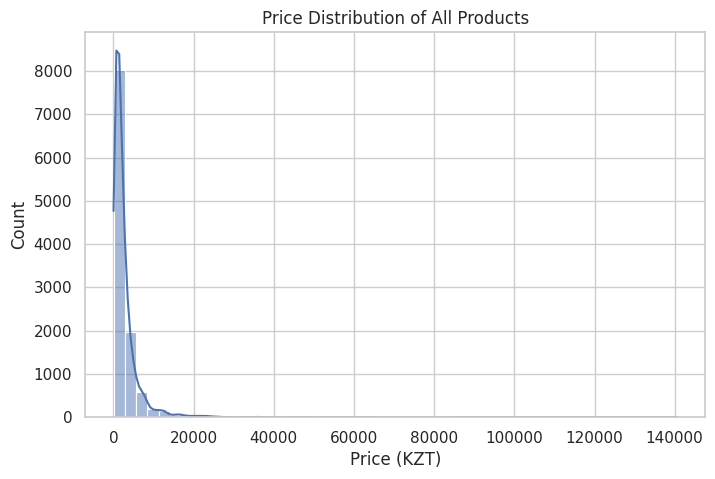

In [ ]:
 plt.figure()
sns.histplot(df_final["price_raw"], bins=50, kde=True)
plt.title("Price Distribution of All Products")
plt.xlabel("Price (KZT)")
plt.ylabel("Count")
plt.show()


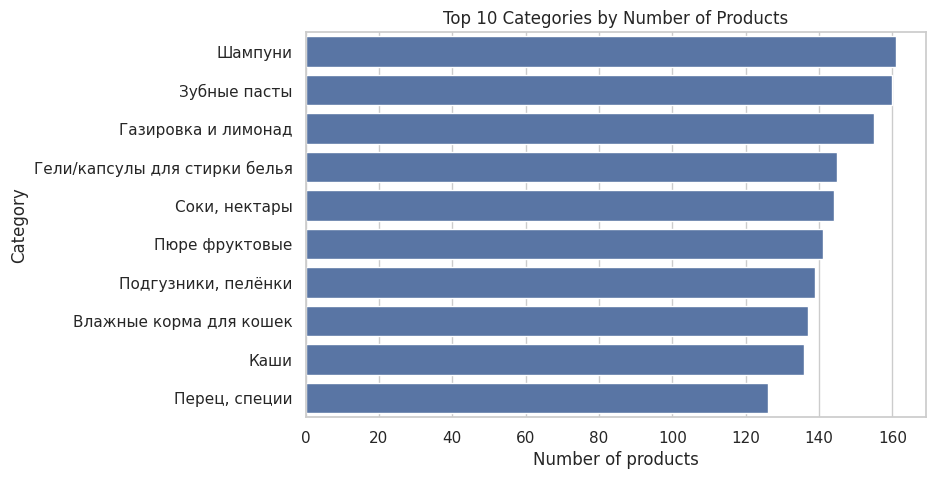

In [ ]:
top_cats = df_final["category"].value_counts().head(10)

plt.figure()
sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title("Top 10 Categories by Number of Products")
plt.xlabel("Number of products")
plt.ylabel("Category")
plt.show()


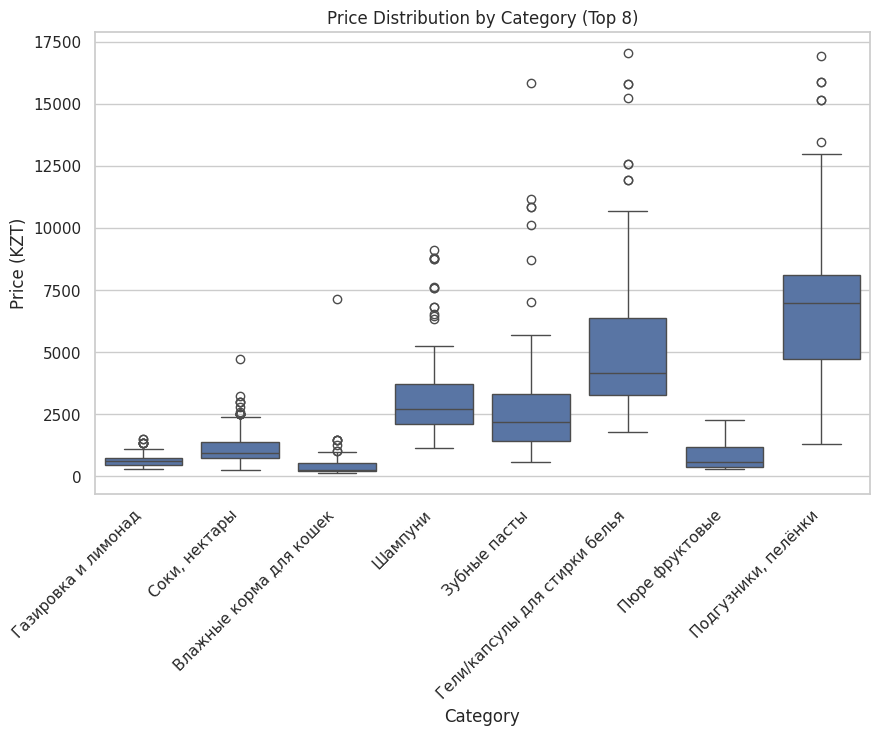

In [ ]:
top8 = df_final["category"].value_counts().head(8).index
subset = df_final[df_final["category"].isin(top8)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x="category", y="price_raw")
plt.xticks(rotation=45, ha="right")
plt.title("Price Distribution by Category (Top 8)")
plt.xlabel("Category")
plt.ylabel("Price (KZT)")
plt.show()


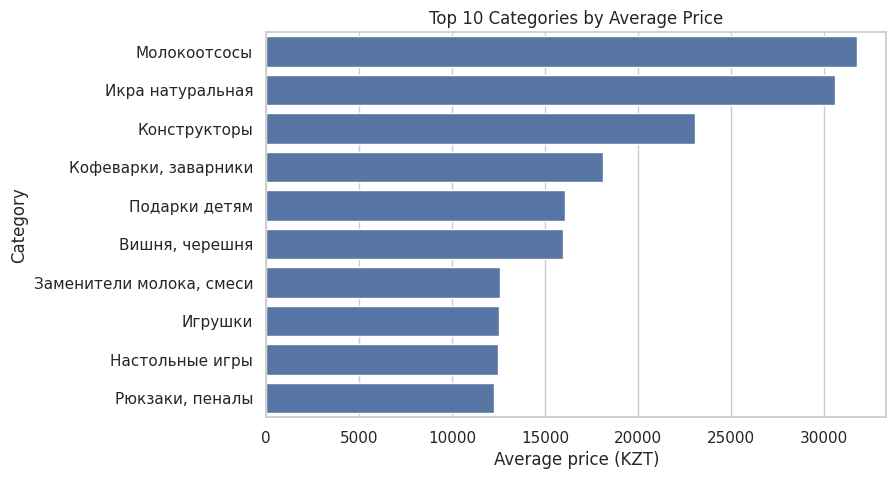

In [ ]:
avg_price_cat = (
    df_final.groupby("category")["price_raw"]
            .mean()
            .sort_values(ascending=False)
            .head(10)
)

plt.figure()
sns.barplot(x=avg_price_cat.values, y=avg_price_cat.index)
plt.title("Top 10 Categories by Average Price")
plt.xlabel("Average price (KZT)")
plt.ylabel("Category")
plt.show()


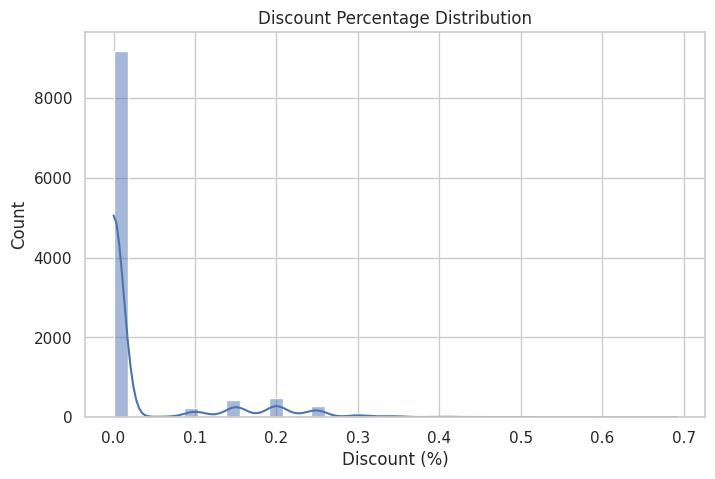

In [ ]:
plt.figure()
sns.histplot(df_final["discount_percent"], bins=40, kde=True)
plt.title("Discount Percentage Distribution")
plt.xlabel("Discount (%)")
plt.ylabel("Count")
plt.show()


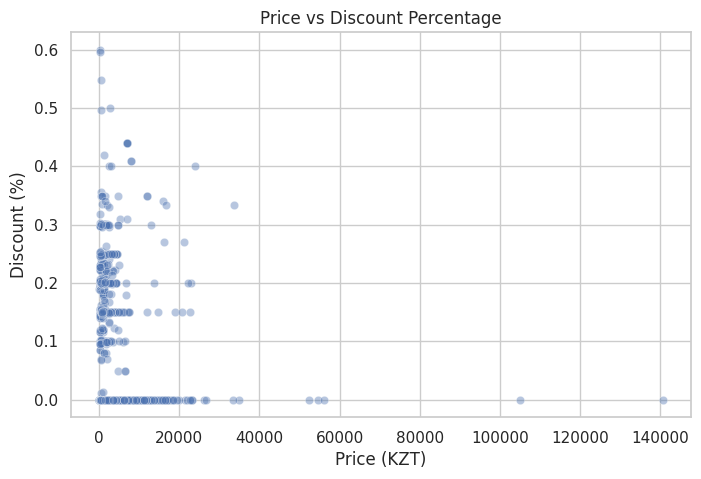

In [ ]:
plt.figure()
sns.scatterplot(
    data=df_final.sample(min(3000, len(df_final))),  # sample to avoid overplotting
    x="price_raw",
    y="discount_percent",
    alpha=0.4
)
plt.title("Price vs Discount Percentage")
plt.xlabel("Price (KZT)")
plt.ylabel("Discount (%)")
plt.show()


In [ ]:
df_final.sort_values("price_raw", ascending=False)[
    ["category", "brand", "name", "price_raw"]
].head(10)


category                    brand  \
1333      Икра натуральная  Русская Каспийская Икра   
8307  Бутылочки, поильники            Philips AVENT   
1327      Икра натуральная           Caspian Caviar   
1355      Икра натуральная        Pearl Of The East   
1337      Икра натуральная           Caspian Caviar   
8832               Игрушки                     Hape   
1334      Икра натуральная  Русская Каспийская Икра   
1299          Морепродукты               Kingfisher   
1336      Икра натуральная           Caspian Caviar   
1338      Икра натуральная           Caspian Caviar   

                                                   name  price_raw  
1333  Икра Русская Каспийская Икра зернистая осетров...   140625.0  
8307  Прибор для приготовления детского питания Phil...   112398.0  
1327         Икра Сaspian Caviar черная осетровая 200 г   108000.0  
1355  Икра Pearl of the East черная осетровая, высши...   105000.0  
1337  Икра Caspian Caviar черная осетровая стерлядь ...   103500.0  
8832                                 Игровой домик Hape    97525.0  
1334  Икра Русская Каспийская зернистая, осетровых р...    56250.0  
1299         Конечности краба Kingfisher Камчатского кг    54600.0  
1336  Икра черная Caspian Caviar сибирского осетра 1...    54000.0  
1338  Икра черная Caspian Caviar осетровая стерлядь ...    54000.0

In [ ]:
df_final.sort_values("price_raw", ascending=True)[
    ["category", "brand", "name", "price_raw"]
].head(10)


category            brand  \
10625         Кондитерские добавки   Эстетика Вкуса   
8859   Канцелярские принадлежности          Айголек   
10645         Кондитерские добавки             Haas   
10665           Для декора выпечки  Русский аппетит   
10668           Для декора выпечки  Русский аппетит   
10667           Для декора выпечки  Русский аппетит   
10251                Перец, специи        Приправыч   
10616         Кондитерские добавки        Dr.Bakers   
10631         Кондитерские добавки         Podravka   
277                    Лук, чеснок              NaN   

                                                    name  price_raw  
10625        Ванилин Эстетика Вкуса кристаллический, 2 г       40.0  
8859   Ручка шариковая Айголек Blue синий стержень, 1 шт       47.0  
10645                                 Ванилин Haas 1.5 г       65.0  
10665     Кондитерские посыпки Русский аппетит бисер, 7г       70.0  
10668    Кондитерские посыпки Русский аппетит звезды, 7г       70.0  
10667  Кондитерские посыпки Русский аппетит вермишель...       70.0  
10251                      Орегано Приправыч сушеный 7 г       75.0  
10616                     Ванилин Dr.Bakers интенсив 2 г       85.0  
10631                               Дрожжи Podravka 11 г       90.0  
277                                     Лук репчатый, кг       92.0

In [ ]:
cat_counts = df_final["category"].value_counts()
cat_counts.head(15)


category
Шампуни                            161
Зубные пасты                       160
Газировка и лимонад                155
Гели/капсулы для стирки белья      145
Соки, нектары                      144
Пюре фруктовые                     141
Подгузники, пелёнки                139
Влажные корма для кошек            137
Каши                               136
Перец, специи                      126
Прокладки гигиенические            117
Универсальные приправы, бульоны    109
ПП-соусы, масла и специи           106
Зубные щетки                       105
Дезодоранты                        102
Name: count, dtype: int64

In [ ]:
avg_price = df_final.groupby("category")["price_raw"].mean().sort_values(ascending=False)
avg_price.head(10)



category
Молокоотсосы                31787.500000
Икра натуральная            30644.555556
Конструкторы                23065.000000
Кофеварки, заварники        18125.000000
Подарки детям               16100.000000
Вишня, черешня              16000.000000
Заменители молока, смеси    12593.844828
Игрушки                     12525.313725
Настольные игры             12471.666667
Рюкзаки, пеналы             12279.000000
Name: price_raw, dtype: float64

In [ ]:
avg_disc = (
    df_final.groupby("category")["discount_percent"]
            .mean()
            .sort_values(ascending=False)
)
avg_disc.head(10)


category
Аксессуары для вечеринок    0.400000
Аксессуары для отдыха       0.392857
Подарки детям               0.340164
Конструкторы                0.333334
Наборы для творчества       0.332803
Основа для пиццы            0.251337
Для бровей                  0.249443
Свечи, топперы для торта    0.240799
Подарочные наборы           0.199805
Вафли                       0.181984
Name: discount_percent, dtype: float64

In [ ]:
corr_price_discount = df_final["price_raw"].corr(df_final["discount_percent"])
corr_price_discount


np.float64(-0.03584965262159293)

In [ ]:
corr_old_disc_amount = df_final["old_price_raw"].corr(df_final["discount_amount"])
corr_old_disc_amount


np.float64(0.3138249205021019)

In [ ]:
global_disc_mean = df_final["discount_percent"].mean()

disc_by_cat = (
    df_final.groupby("category")["discount_percent"]
            .mean()
            .sort_values(ascending=False)
)

global_disc_mean, disc_by_cat.head(10), disc_by_cat.tail(10)


(np.float64(0.03367451003634956),
 category
 Аксессуары для вечеринок    0.400000
 Аксессуары для отдыха       0.392857
 Подарки детям               0.340164
 Конструкторы                0.333334
 Наборы для творчества       0.332803
 Основа для пиццы            0.251337
 Для бровей                  0.249443
 Свечи, топперы для торта    0.240799
 Подарочные наборы           0.199805
 Вафли                       0.181984
 Name: discount_percent, dtype: float64,
 category
 Фарш куринный             0.0
 В вафельном рожке         0.0
 Фильтры для воды          0.0
 Формы для выпечки         0.0
 Фруктовый лед и сорбет    0.0
 Фрукты прочие             0.0
 Хлеб замороженный         0.0
 Яблоки, груши             0.0
 Ягодные миксы             0.0
 Ягоды прочие              0.0
 Name: discount_percent, dtype: float64)

In [ ]:
cat = "Помидоры"  # change to any category present in your data
(
    df_final[df_final["category"] == cat]["brand"]
        .value_counts()
        .head(10)
)


brand
NacAgro                2
Ayakaz                 1
Be Fresh Produce BV    1
Name: count, dtype: int64